# Part 1 Library Imports & Google Drive Mount

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt


# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Part2 Data Loading and Splitting 

Source:

[1] Lab2: https://colab.research.google.com/drive/1cxfHtc4TFWSblAiyHQec3z_vnh1WEAFW?usp=sharing

In [ ]:
# Define the transform to be performed on the data [1]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((64,64)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

classes = ('P', 'N')

# Define the path to the data on the drive [1]:
# The data is splitted manually into three folders (train, validate, test):
trainset=torchvision.datasets.ImageFolder("/content/gdrive/My Drive/Colab Notebooks/Smiling_Machine/train_small", transform=transform)
#validateset=torchvision.datasets.ImageFolder('/content/gdrive/My Drive/Colab Notebooks/Smiling_Machine/validate_p_small', transform=transform)
#testset=torchvision.datasets.ImageFolder('/content/gdrive/My Drive/Colab Notebooks/Smiling_Machine/test_p_small', transform=transform)

# Generate the loaders [1]
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                               num_workers=1)
#validate_loader = torch.utils.data.DataLoader(validateset, batch_size=1,
                                               #num_workers=1)
#test_loader = torch.utils.data.DataLoader(testset, batch_size=1,
                                               #num_workers=1)

# Part3 Initalize Weight

According to the paper "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks" (https://arxiv.org/abs/1511.06434), "All weights were initialized from a zero-centered Normal distribution
with standard deviation 0.02." The team has some difficulty in understanding the exact math content behind this line, but find the following implementation that initilize the weights in a desired way. After research on and learning this piece of code, the team reaches to the conclusion that it is useful and reliable. Thus, the team will also use it to initialize the weights for the team's model after giving credit to it by detailed citation.

This code is directly extratced from: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html


In [ ]:
# custom weights initialization called on netG and netD
def initialize_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Part4 Model Setup 





> Discriminator

The discriminator architecture is based on 

(1) The DCGAN model tutorial from PyTorch (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)  

(2) Suggestion on the DCGAN architecture from paper "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks" (https://arxiv.org/abs/1511.06434) 

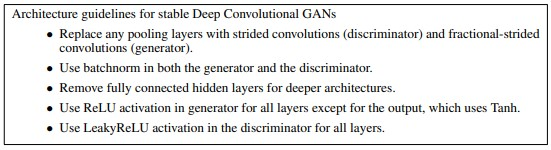

(3) Some other existing models: 
*  https://www.youtube.com/watch?v=Hp-jWm2SzR8
*  https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs
*  https://colab.research.google.com/github/drc10723/GAN_design/blob/master/GAN_implementations/Conditional_DCGAN_MNIST.ipynb)
*  GAN model from APS360 lecture notes from 2019 (https://www.cs.toronto.edu/~lczhang/360/lec/w09/gan.html) 





In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input = N x 3 x 64 x 64 
            # nn.Conv2d(i,o,k,s,p)
            # 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            # 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 8 x 8 
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # 4 x 4 
            nn.Conv2d(512, 1, 4, 1, 0),
            nn.Sigmoid()
        )
    def forward(self, x):
        # size of x:  N x 3 x 64 x 64 
        # size of model: N x 1 x 1 x 1
        model = self.model(x)

        # return size: N
        return model

In [ ]:
# Print the architecture of the GAN
D = Discriminator()
D.cuda()
D.apply(initialize_weights)
print(D)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)



> Generator 

The generator architecture is based on 

(1) The DCGAN model tutorial from PyTorch (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)  

(2) Suggestion on the DCGAN architecture from paper "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks" (https://arxiv.org/abs/1511.06434)

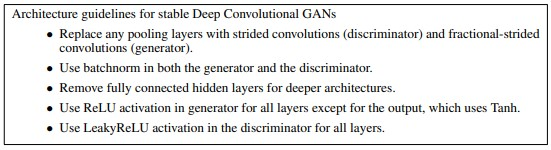

(3) Some other existing models: 
* https://www.youtube.com/watch?v=Hp-jWm2SzR8
* https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs
* https://colab.research.google.com/github/drc10723/GAN_design/blob/master/GAN_implementations/Conditional_DCGAN_MNIST.ipynb)
*  GAN model from APS360 lecture notes from 2019 (https://www.cs.toronto.edu/~lczhang/360/lec/w09/gan.html) 

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # input = N x 100 x 1 x 1
            # nn.Conv2d(i,o,k,s,p,op)
            # 1 x 1 
            nn.ConvTranspose2d(100, 512, 4, 1, 0, 0),
            nn.BatchNorm2d(512, 0.1),
            nn.ReLU(),
            # 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, 0),
            nn.BatchNorm2d(256, 0.1),
            nn.ReLU(),
            # 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, 0),
            nn.BatchNorm2d(128, 0.1),
            nn.ReLU(),
            # 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, 0),
            nn.BatchNorm2d(64, 0.1),
            nn.ReLU(),
            # 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, 0),
            nn.Tanh()
            # output = N x 3 x 64 x 64
        )
    def forward(self, x):
      # size of x: N x 100 x 1 x 1

      # return size: N x 3 x 64 x 64 
      return self.model(x)

In [ ]:
# Print the architecture of the GAN
G = Generator()
G.cuda()
G.apply(initialize_weights)
print(G)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)


# Part5 GPU Enabling



In [ ]:
# Enable run on GPU:
use_cuda = True

# Part6 Training

The training proceduer is based on 

(1) The DCGAN model tutorial from PyTorch (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)  

(2) Suggestion on the DCGAN architecture from paper "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks": use BCE as loss function and use Adam optimizer with a learning rate of 0.0002 (https://arxiv.org/abs/1511.06434) 

(3) Some other existing models: 
* https://www.youtube.com/watch?v=Hp-jWm2SzR8
* https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs
* https://colab.research.google.com/github/drc10723/GAN_design/blob/master/GAN_implementations/Conditional_DCGAN_MNIST.ipynb)
* GAN model training procedurefrom APS360 lecture notes from 2019 (https://www.cs.toronto.edu/~lczhang/360/lec/w09/gan.html)  

Epoch: 0 / 1 D_loss: 1.910700798034668 G_loss: 3.3281660079956055


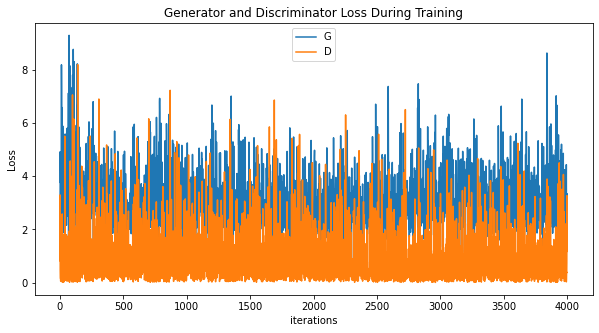

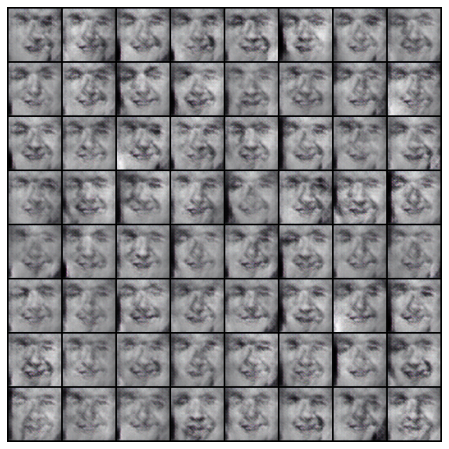

In [ ]:
lr = 0.0002
batch_size = 128
num_epochs = 1

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
test_noise = torch.randn(64, 100, 1, 1)

# Establish convention for real and fake labels during training
real = 1.
fake = 0.

# Setup Adam optimizers for both G and D
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

#############################################
#To Enable GPU Usage
if use_cuda and torch.cuda.is_available():
  test_noise = test_noise.cuda()
#############################################

img_generated = []
G_losses = []
D_losses = []

for epoch in range(num_epochs):
  for n, (images, s_label) in enumerate(train_loader):
    # images size: N x 3 x 64 x 64
    #print(images.shape)
            
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      images = images.cuda()
    #############################################

    # === Train the Discriminator ===
    D.zero_grad()
    label = torch.full((images.size(0),), real, dtype=torch.float)
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      label = label.cuda()
    #############################################

    D_output_real = D(images).view(-1)


    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      D_output_real = D_output_real.cuda()
    #############################################

    D_loss_real = criterion(D_output_real, label)
    D_loss_real.backward()
    D_x = D_output_real.mean().item()
            
    noise = torch.randn(images.size(0), 100, 1, 1)
            #print(noise.shape)

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      noise = noise.cuda()
    #############################################

    fake_images = G(noise)

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      fake_images = fake_images.cuda()
    #############################################

    label.fill_(fake)
    D_output_fake = D(fake_images.detach()).view(-1)

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      D_output_fake = D_output_fake.cuda()
    #############################################
            
    D_loss_fake = criterion(D_output_fake, label)
    D_loss_fake.backward()
    D_G_z1 = D_output_fake.mean().item()

    D_loss = D_loss_real + D_loss_fake
    d_optimizer.step()

    G.zero_grad()

    label.fill_(real)

    D_output_fake = D(fake_images).view(-1)
            #print(D_output_fake.shape)

    G_loss = criterion(D_output_fake, label)
    G_loss.backward()
    D_G_z2 = D_output_fake.mean().item()
    g_optimizer.step()

    D_losses.append(D_loss.item())
    G_losses.append(G_loss.item())
            # print(G_losses)

  print("Epoch:", epoch,"/",num_epochs, "D_loss:", D_loss.item(),"G_loss:", G_loss.item())

  with torch.no_grad():
    test_images = G(test_noise).detach().cpu()
  img_generated.append(vutils.make_grid(test_images, padding=2, normalize=True))

# plot loss curves: 
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# plot images generated: 
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)))] for i in img_generated]

Epoch: 0 / 5 D_loss: 0.06676893681287766 G_loss: 5.079668045043945
Epoch: 1 / 5 D_loss: 2.395874261856079 G_loss: 3.837454080581665
Epoch: 2 / 5 D_loss: 1.869004249572754 G_loss: 2.2849338054656982
Epoch: 3 / 5 D_loss: 0.46466296911239624 G_loss: 2.2158915996551514
Epoch: 4 / 5 D_loss: 1.099406123161316 G_loss: 4.792133808135986


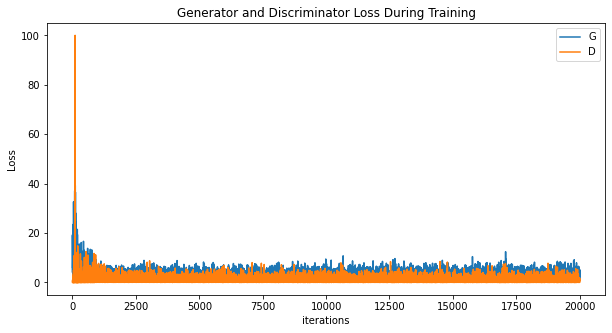

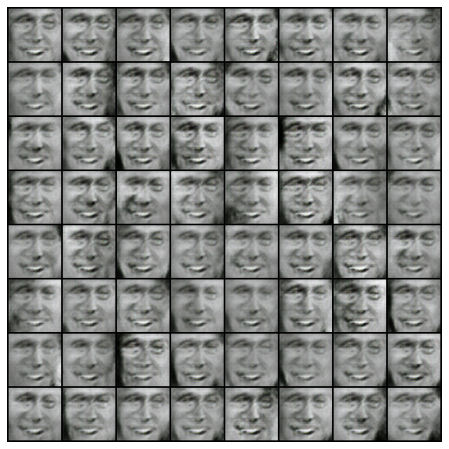

In [ ]:
lr = 0.0002
batch_size = 128
num_epochs = 100

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
test_noise = torch.randn(64, 100, 1, 1)

# Establish convention for real and fake labels during training
real = 1.
fake = 0.

# Setup Adam optimizers for both G and D
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

#############################################
#To Enable GPU Usage
if use_cuda and torch.cuda.is_available():
  test_noise = test_noise.cuda()
#############################################

img_generated = []
G_losses = []
D_losses = []

for epoch in range(num_epochs):
  for n, (images, s_label) in enumerate(train_loader):
    # images size: N x 3 x 64 x 64
    #print(images.shape)
            
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      images = images.cuda()
    #############################################

    # === Train the Discriminator ===
    D.zero_grad()
    label = torch.full((images.size(0),), real, dtype=torch.float)
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      label = label.cuda()
    #############################################

    D_output_real = D(images).view(-1)


    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      D_output_real = D_output_real.cuda()
    #############################################

    D_loss_real = criterion(D_output_real, label)
    D_loss_real.backward()
    D_x = D_output_real.mean().item()
            
    noise = torch.randn(images.size(0), 100, 1, 1)
            #print(noise.shape)

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      noise = noise.cuda()
    #############################################

    fake_images = G(noise)

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      fake_images = fake_images.cuda()
    #############################################

    label.fill_(fake)
    D_output_fake = D(fake_images.detach()).view(-1)

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      D_output_fake = D_output_fake.cuda()
    #############################################
            
    D_loss_fake = criterion(D_output_fake, label)
    D_loss_fake.backward()
    D_G_z1 = D_output_fake.mean().item()

    D_loss = D_loss_real + D_loss_fake
    d_optimizer.step()

    G.zero_grad()

    label.fill_(real)

    D_output_fake = D(fake_images).view(-1)
            #print(D_output_fake.shape)

    G_loss = criterion(D_output_fake, label)
    G_loss.backward()
    D_G_z2 = D_output_fake.mean().item()
    g_optimizer.step()

    D_losses.append(D_loss.item())
    G_losses.append(G_loss.item())
            # print(G_losses)

  print("Epoch:", epoch,"/",num_epochs, "D_loss:", D_loss.item(),"G_loss:", G_loss.item())

  with torch.no_grad():
    test_images = G(test_noise).detach().cpu()
  img_generated.append(vutils.make_grid(test_images, padding=2, normalize=True))

# plot loss curves: 
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# plot images generated: 
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)))] for i in img_generated]

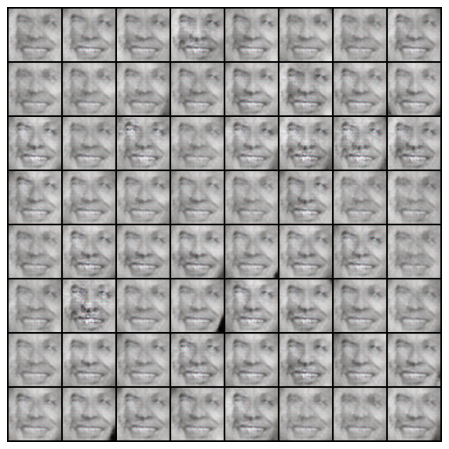

In [ ]:
lr = 0.0002
batch_size = 128
num_epochs = 10

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
test_noise = torch.randn(64, 100, 1, 1)

# Establish convention for real and fake labels during training
real = 1.
fake = 0.

# Setup Adam optimizers for both G and D
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

#############################################
#To Enable GPU Usage
if use_cuda and torch.cuda.is_available():
  test_noise = test_noise.cuda()
#############################################

img_generated = []
G_losses = []
D_losses = []

for epoch in range(num_epochs):
  for n, (images, s_label) in enumerate(train_loader):
    # images size: N x 3 x 64 x 64
    #print(images.shape)
            
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      images = images.cuda()
    #############################################

    # === Train the Discriminator ===
    D.zero_grad()
    label = torch.full((images.size(0),), real, dtype=torch.float)
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      label = label.cuda()
    #############################################

    D_output_real = D(images).view(-1)


    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      D_output_real = D_output_real.cuda()
    #############################################

    D_loss_real = criterion(D_output_real, label)
    D_loss_real.backward()
    D_x = D_output_real.mean().item()
            
    noise = torch.randn(images.size(0), 100, 1, 1)
            #print(noise.shape)

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      noise = noise.cuda()
    #############################################

    fake_images = G(noise)

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      fake_images = fake_images.cuda()
    #############################################

    label.fill_(fake)
    D_output_fake = D(fake_images.detach()).view(-1)

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      D_output_fake = D_output_fake.cuda()
    #############################################
            
    D_loss_fake = criterion(D_output_fake, label)
    D_loss_fake.backward()
    D_G_z1 = D_output_fake.mean().item()

    D_loss = D_loss_real + D_loss_fake
    d_optimizer.step()

    G.zero_grad()

    label.fill_(real)

    D_output_fake = D(fake_images).view(-1)
            #print(D_output_fake.shape)

    G_loss = criterion(D_output_fake, label)
    G_loss.backward()
    D_G_z2 = D_output_fake.mean().item()
    g_optimizer.step()

    D_losses.append(D_loss.item())
    G_losses.append(G_loss.item())
            # print(G_losses)


  test_noise = torch.randn(64, 100, 1, 1)
  test_noise = test_noise.cuda()


  with torch.no_grad():
    test_images = G(test_noise).detach().cpu()
  img_generated.append(vutils.make_grid(test_images, padding=2, normalize=True))

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)))] for i in img_generated]


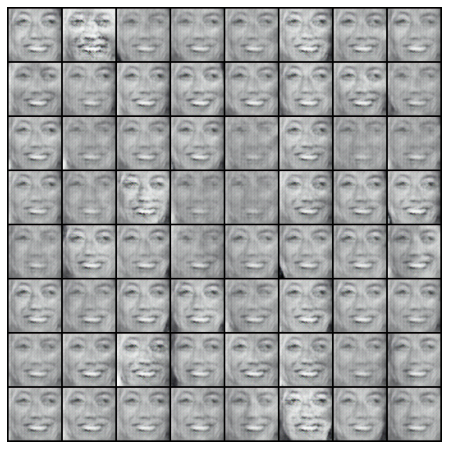

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)))] for i in img_generated]

In [ ]:
test_noise = torch.randn(64, 100, 1, 1)
img = G(test_noise).detach().cpu()
plt.imgshow(img)

Epoch: 0 / 100 D_loss: 0.11865644156932831 G_loss: 2.6487019062042236
Epoch: 1 / 100 D_loss: 0.5630642175674438 G_loss: 2.6754226684570312
Epoch: 2 / 100 D_loss: 0.6917718648910522 G_loss: 3.4475653171539307
Epoch: 3 / 100 D_loss: 0.3639281392097473 G_loss: 3.406907796859741
Epoch: 4 / 100 D_loss: 1.2715258598327637 G_loss: 2.738319158554077
Epoch: 5 / 100 D_loss: 0.15951576828956604 G_loss: 3.870033025741577
Epoch: 6 / 100 D_loss: 0.07376792281866074 G_loss: 2.9448747634887695
Epoch: 7 / 100 D_loss: 0.02905893698334694 G_loss: 4.368246078491211
Epoch: 8 / 100 D_loss: 0.12451241910457611 G_loss: 6.0955586433410645
Epoch: 9 / 100 D_loss: 1.236960530281067 G_loss: 3.185976505279541
Epoch: 10 / 100 D_loss: 0.3167494535446167 G_loss: 2.628286838531494
Epoch: 11 / 100 D_loss: 0.08157119899988174 G_loss: 3.820034980773926
Epoch: 12 / 100 D_loss: 0.0017538836691528559 G_loss: 8.359257698059082
Epoch: 13 / 100 D_loss: 0.0013916988391429186 G_loss: 6.683375358581543
Epoch: 14 / 100 D_loss: 0.07

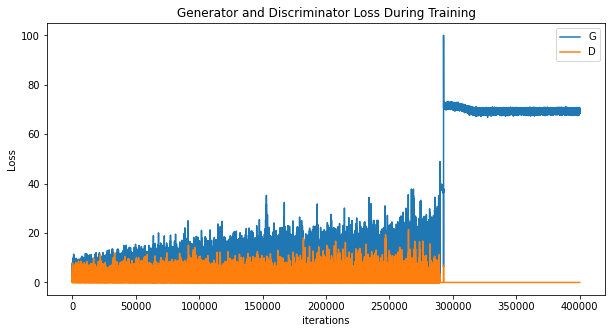

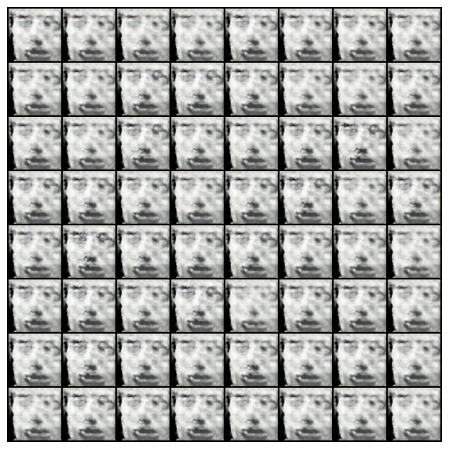

In [ ]:
lr = 0.0002
batch_size = 128
num_epochs = 100

# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real = 1.
fake = 0.

# Setup Adam optimizers for both G and D
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

#############################################
#To Enable GPU Usage
if use_cuda and torch.cuda.is_available():
  test_noise = test_noise.cuda()
#############################################

img_generated = []
G_losses = []
D_losses = []

for epoch in range(num_epochs):
  for n, (images, s_label) in enumerate(train_loader):
    # images size: N x 3 x 64 x 64
    #print(images.shape)
            
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      images = images.cuda()
    #############################################

    # === Train the Discriminator ===
    D.zero_grad()
    label = torch.full((images.size(0),), real, dtype=torch.float)
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      label = label.cuda()
    #############################################

    D_output_real = D(images).view(-1)


    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      D_output_real = D_output_real.cuda()
    #############################################

    D_loss_real = criterion(D_output_real, label)
    D_loss_real.backward()
    D_x = D_output_real.mean().item()
            
    noise = torch.randn(images.size(0), 100, 1, 1)
            #print(noise.shape)

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      noise = noise.cuda()
    #############################################

    fake_images = G(noise)

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      fake_images = fake_images.cuda()
    #############################################

    label.fill_(fake)
    D_output_fake = D(fake_images.detach()).view(-1)

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      D_output_fake = D_output_fake.cuda()
    #############################################
            
    D_loss_fake = criterion(D_output_fake, label)
    D_loss_fake.backward()
    D_G_z1 = D_output_fake.mean().item()

    D_loss = D_loss_real + D_loss_fake
    d_optimizer.step()

    G.zero_grad()

    label.fill_(real)

    D_output_fake = D(fake_images).view(-1)
            #print(D_output_fake.shape)

    G_loss = criterion(D_output_fake, label)
    G_loss.backward()
    D_G_z2 = D_output_fake.mean().item()
    g_optimizer.step()

    D_losses.append(D_loss.item())
    G_losses.append(G_loss.item())
            # print(G_losses)


  test_noise = torch.randn(64, 100, 1, 1)
  with torch.no_grad():
    test_images = G(test_noise).detach().cpu()
  img_generated.append(vutils.make_grid(test_images, padding=2, normalize=True))

# plot images generated: 
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)))] for i in img_generated]

Epoch: 0 / 20 D_loss: 0.0 G_loss: 70.31876373291016
Epoch: 1 / 20 D_loss: 0.0 G_loss: 69.65467834472656
Epoch: 2 / 20 D_loss: 0.0 G_loss: 69.62218475341797
Epoch: 3 / 20 D_loss: 0.0 G_loss: 69.76112365722656
Epoch: 4 / 20 D_loss: 0.0 G_loss: 69.56995391845703
Epoch: 5 / 20 D_loss: 0.0 G_loss: 70.24347686767578
Epoch: 6 / 20 D_loss: 0.0 G_loss: 69.15442657470703
Epoch: 7 / 20 D_loss: 0.0 G_loss: 69.70320892333984
Epoch: 8 / 20 D_loss: 0.0 G_loss: 70.00362396240234
Epoch: 9 / 20 D_loss: 0.0 G_loss: 69.1561279296875
Epoch: 10 / 20 D_loss: 0.0 G_loss: 70.46791076660156
Epoch: 11 / 20 D_loss: 0.0 G_loss: 69.58978271484375
Epoch: 12 / 20 D_loss: 0.0 G_loss: 69.4908447265625
Epoch: 13 / 20 D_loss: 0.0 G_loss: 69.71675109863281
Epoch: 14 / 20 D_loss: 0.0 G_loss: 68.65044403076172
Epoch: 15 / 20 D_loss: 0.0 G_loss: 70.13887786865234
Epoch: 16 / 20 D_loss: 0.0 G_loss: 69.7112045288086
Epoch: 17 / 20 D_loss: 0.0 G_loss: 69.9430160522461
Epoch: 18 / 20 D_loss: 0.0 G_loss: 69.83280181884766
Epoch: 

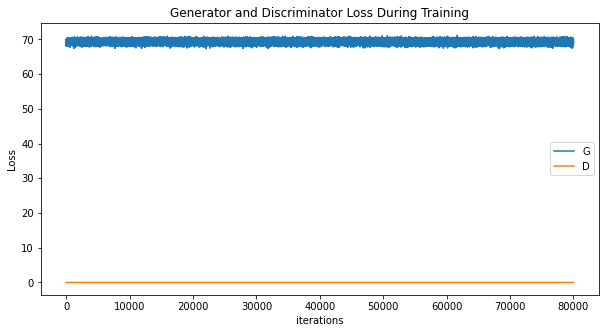

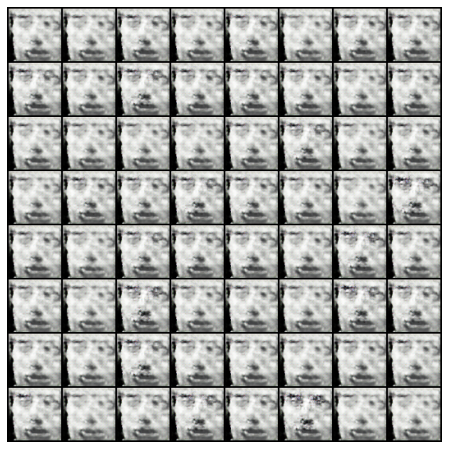

In [ ]:
lr = 0.0002
batch_size = 128
num_epochs = 20

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
test_noise = torch.randn(64, 100, 1, 1)

# Establish convention for real and fake labels during training
real = 1.
fake = 0.

# Setup Adam optimizers for both G and D
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

#############################################
#To Enable GPU Usage
if use_cuda and torch.cuda.is_available():
  test_noise = test_noise.cuda()
#############################################

img_generated = []
G_losses = []
D_losses = []

for epoch in range(num_epochs):
  for n, (images, s_label) in enumerate(train_loader):
    # images size: N x 3 x 64 x 64
    #print(images.shape)
            
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      images = images.cuda()
    #############################################

    # === Train the Discriminator ===
    D.zero_grad()
    label = torch.full((images.size(0),), real, dtype=torch.float)
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      label = label.cuda()
    #############################################

    D_output_real = D(images).view(-1)


    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      D_output_real = D_output_real.cuda()
    #############################################

    D_loss_real = criterion(D_output_real, label)
    D_loss_real.backward()
    D_x = D_output_real.mean().item()
            
    noise = torch.randn(images.size(0), 100, 1, 1)
            #print(noise.shape)

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      noise = noise.cuda()
    #############################################

    fake_images = G(noise)

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      fake_images = fake_images.cuda()
    #############################################

    label.fill_(fake)
    D_output_fake = D(fake_images.detach()).view(-1)

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      D_output_fake = D_output_fake.cuda()
    #############################################
            
    D_loss_fake = criterion(D_output_fake, label)
    D_loss_fake.backward()
    D_G_z1 = D_output_fake.mean().item()

    D_loss = D_loss_real + D_loss_fake
    d_optimizer.step()

    G.zero_grad()

    label.fill_(real)

    D_output_fake = D(fake_images).view(-1)
            #print(D_output_fake.shape)

    G_loss = criterion(D_output_fake, label)
    G_loss.backward()
    D_G_z2 = D_output_fake.mean().item()
    g_optimizer.step()

    D_losses.append(D_loss.item())
    G_losses.append(G_loss.item())
            # print(G_losses)

  print("Epoch:", epoch,"/",num_epochs, "D_loss:", D_loss.item(),"G_loss:", G_loss.item())

  with torch.no_grad():
    test_images = G(test_noise).detach().cpu()
  img_generated.append(vutils.make_grid(test_images, padding=2, normalize=True))

# plot loss curves: 
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# plot images generated: 
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)))] for i in img_generated]